# Modelo de HP para decomponer tendencia y ciclo
Este proyecto lo hago con el objetivo de entender como se comporta la tasa de cambio para poder crear estrategias de cobertura para exportadores

In [1]:
!pip install statsmodels
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt

### Datos de la TRM para colombia
voy a definir el plazo de tiempo en un mes con el objetivo de ver relaciones a más largo plazo por la caracteristica de las operaciones que van a hacer los clientes

In [3]:
trm=pd.read_excel("TRM_historico.xlsx",index_col=0)

In [4]:
trm_m=trm#.resample("m").last()
trm_m.head()

,TRM
Fecha,
2000-01-01,1873.77
2000-01-02,1873.77
2000-01-03,1873.77
2000-01-04,1874.35
2000-01-05,1895.97


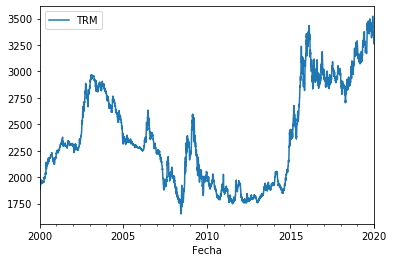

In [5]:
trm_m.plot()

### Filtro de HP

In [6]:
#### Codigo para el HP
cycle, trend=sm.tsa.filters.hpfilter(trm_m, 100*(365)**2)
cycle_1=pd.DataFrame(cycle)
trend_1=pd.DataFrame(trend)

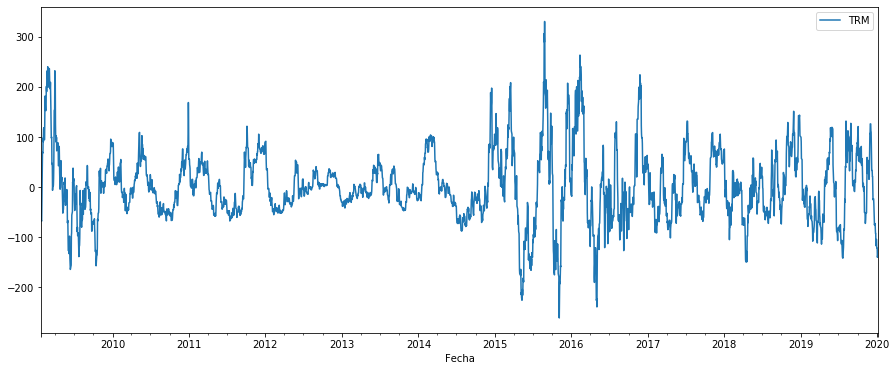

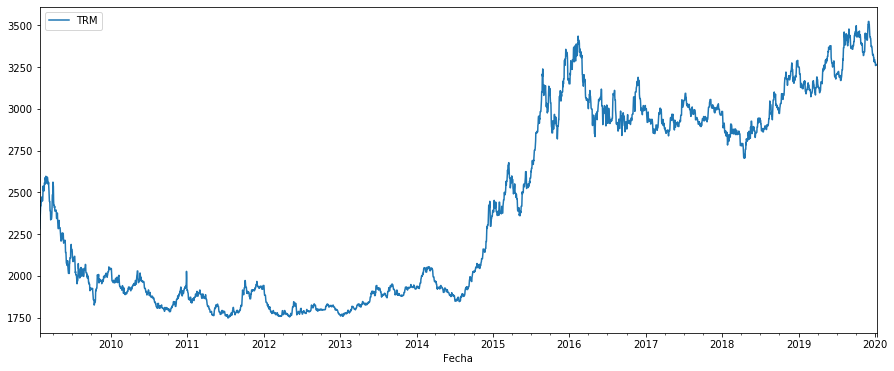

In [7]:
cycle_1[-4000:].plot(figsize=(15,6))
trm[-4000:].plot(figsize=(15,6))
plt.show()

# Oscilador a partir del ciclo de HP

In [72]:
def cot_oscillator(df_1,D):
    cycle, trend=sm.tsa.filters.hpfilter(df_1, 100*(365)**2)
    df=pd.DataFrame(cycle)
    trend_1=pd.DataFrame(trend)
    oscilador=1-1*(df.rolling(window=D).max()-df)/(df.rolling(window=D).max()-df.rolling(window=D).min())
    return pd.DataFrame(oscilador)

In [73]:
cot_oscillator(trm_m,365)[-1:]

,TRM
Fecha,
2020-01-08,0.025231


In [402]:
prueba=len(trm_m)-1000
posicion=pd.DataFrame()
for i in range(0,prueba+1):
    base=(trm_m[:len(trm_m)-prueba+i])
    posicion=posicion.append(cot_oscillator(base,365)[-1:],sort=True)
    
posicion=posicion.shift(1)

In [403]:
posicion=posicion.dropna()
posicion.head()

,TRM
Fecha,
2002-09-27,0.845402
2002-09-28,0.952274
2002-09-29,0.948566
2002-09-30,0.929092
2002-10-01,0.909091


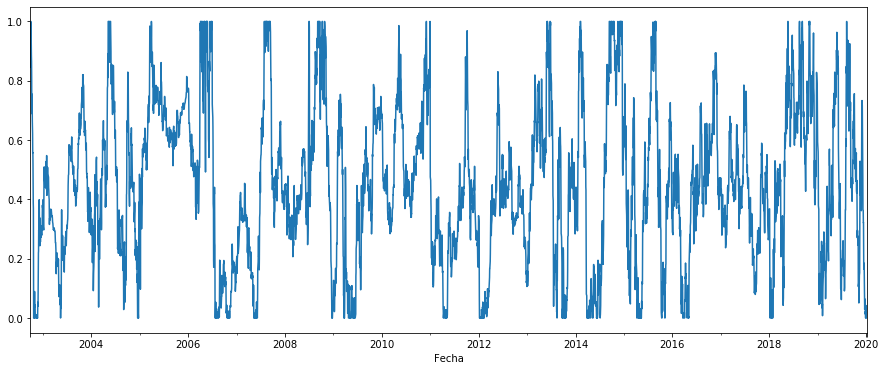

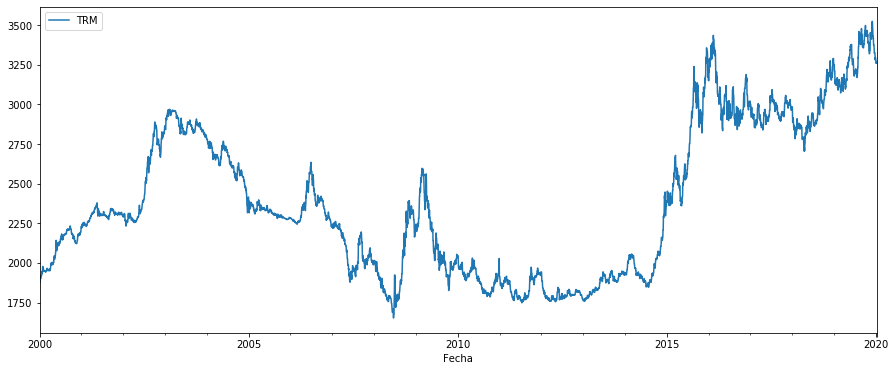

In [404]:
posicion[posicion.columns[0]].plot(figsize=(15,6))
trm_m[:].plot(figsize=(15,6))
plt.show()

# Retornos
voy a hacer un backtest de la strategia por ahora sería in sample, más adelante la voy a dejar out of sample

In [405]:
trm_r=(np.log(trm_m)-np.log(trm_m.shift(1)))*100

In [406]:
estrategia=trm_r

In [407]:
estrategia["posicion"]=posicion[posicion.columns[0]]
estrategia=estrategia.dropna()
estrategia.head()

,TRM,posicion
Fecha,,
2002-09-27,0.817399,0.845402
2002-09-28,0.097640,0.952274
2002-09-29,0.000000,0.948566
2002-09-30,0.000000,0.929092
2002-10-01,0.794900,0.909091


In [408]:
retorno=estrategia[estrategia.columns[0]]*estrategia[estrategia.columns[1]]

In [409]:
inicio=len(trm_m)-len(retorno)

[]

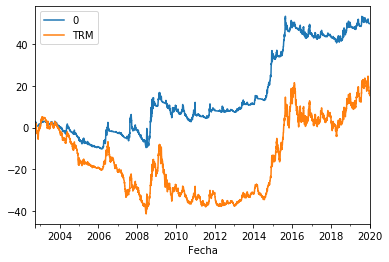

In [410]:
pd.DataFrame(retorno.cumsum()).join((trm_m/trm.iloc[inicio])*100-100).plot()
plt.plot()

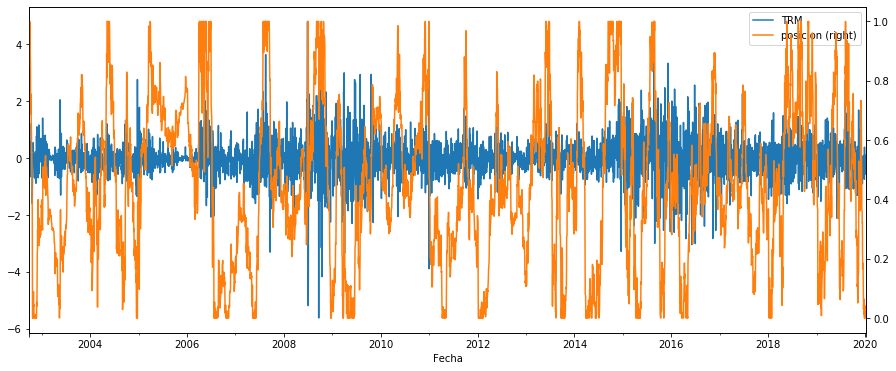

In [411]:
estrategia.plot(secondary_y="posicion",figsize=(15,6))

# backtest

In [592]:
posicion["95%"]=1
posicion["5%"]=0
posicion["zona_l"]=np.where(posicion["TRM"]<=posicion["5%"],-1,0)#np.where(posicion["TRM"]>posicion["95%"],1,0)
posicion["long"]=posicion["zona_l"].diff()
posicion["zona_s"]=np.where(posicion["TRM"]>=posicion["95%"],1,0)
posicion["short"]=posicion["zona_s"].diff()

#
posicion.head(50)

,TRM,95%,5%,zona_l,long,zona_s,short,short_position,short_stock_position
Fecha,,,,,,,,,
2002-09-27,0.845402,1,0,0,NaN,0,NaN,0,0
2002-09-28,0.952274,1,0,0,0.0,0,0.0,0,0
2002-09-29,0.948566,1,0,0,0.0,0,0.0,0,0
2002-09-30,0.929092,1,0,0,0.0,0,0.0,0,0
2002-10-01,0.909091,1,0,0,0.0,0,0.0,0,0
2002-10-02,1.000000,1,0,0,0.0,1,1.0,0,0
2002-10-03,1.000000,1,0,0,0.0,1,0.0,0,0
2002-10-04,0.997158,1,0,0,0.0,0,-1.0,0,0
2002-10-05,0.948176,1,0,0,0.0,0,0.0,0,0


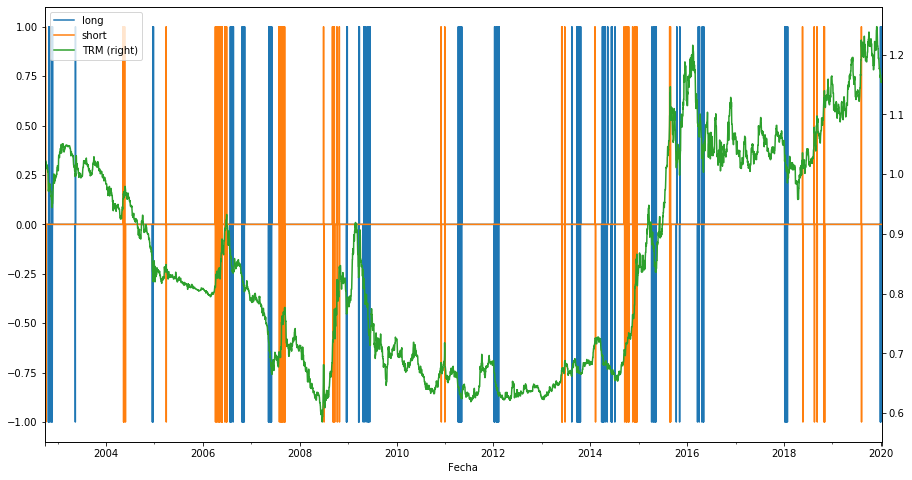

In [593]:
(pd.DataFrame(posicion[["long","short"]]).join(pd.DataFrame(trm_m/trm_m.iloc[inicio]))).plot(secondary_y="TRM",figsize=(15,8))

In [594]:
posicion['short_position'] = 0
posicion['short_stock_position'] = 0
position_short=0
number_stocks=0
dias=0
for i, item in enumerate(posicion['short']):
    dias+=1
    if item==-1 and position_short>=0:
        position_short+=-1
        dias=0
    if dias==60 and position_short<=0:
        position_short=0
    #if posicion["long"][i]==1 and position_short<=0:
    #    position_short=0
    #elif posicion["TRM"][i]<0.5 and position_short<=0:
    #    position_short=0
        
    #if posicion["long"][i]==1 and position_short<=0:
    #    position_short+=1
    #if posicion["short"][i]==-1 and position_short>=0:
    #    position_short=0
    #elif posicion["TRM"][i]>0.5 and position_short>=0:
    #    position_short=0

    posicion['short_position'][i] = position_short
    

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


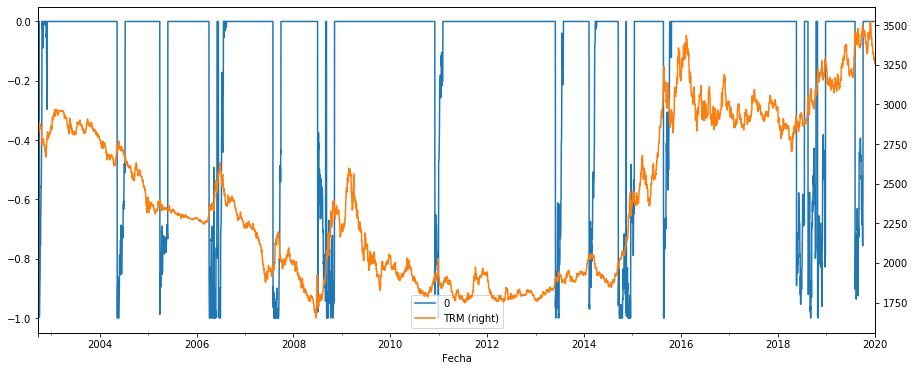

In [595]:
(pd.DataFrame(posicion['short_position']*posicion['TRM']).join(trm_m)).plot(secondary_y="TRM", figsize=(15,6))

In [596]:
estrategia["short"]=posicion['short_position']#*posicion['TRM']
estrategia.head()

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,TRM,posicion,short
Fecha,,,
2002-09-27,0.817399,0.845402,0
2002-09-28,0.097640,0.952274,0
2002-09-29,0.000000,0.948566,0
2002-09-30,0.000000,0.929092,0
2002-10-01,0.794900,0.909091,0


In [597]:
retorno_short=estrategia[estrategia.columns[0]]*estrategia[estrategia.columns[2]]

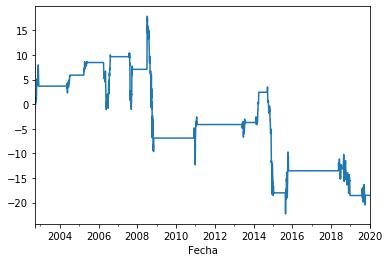

In [598]:
retorno_short.cumsum().plot()

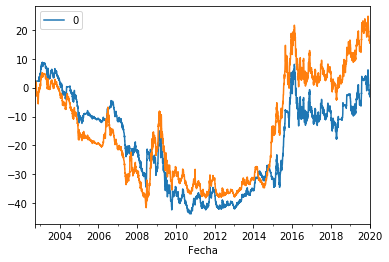

In [599]:
df=pd.DataFrame(retorno_short.cumsum(),columns=["indc"]).join((trm_m/trm.iloc[inicio])*100-100)
(pd.DataFrame(df[df.columns[1]]+df[df.columns[0]])).plot()
df["TRM"].plot()
plt.show()

In [543]:
df

,indc,TRM
Fecha,,
2002-09-27,0.000000,0.000000
2002-09-28,0.000000,0.097688
2002-09-29,0.000000,0.097688
2002-09-30,0.000000,0.097688
2002-10-01,0.000000,0.896536
...,...,...
2020-01-04,-18.814147,15.457718
2020-01-05,-18.814147,15.457718
2020-01-06,-18.814147,15.457718
